# Electrochemical CO sensor data preprocessing

- Pollutant: Carbon Monoxide
- Sensor: Alphasense CO-B4

## Tags description
### Based on AQMesh quality control data for their sensors

- Stabilizing (STABILIZING): Stabilisation is a period whereby a sensor provides “bad” data due to not being in a state of equilibrium. Once the sensor settles in its environment after being recently moved in a manner which may shock or destabilise the sensor or after its being first installed, it will provide usable data. This process takes 2 days to complete for electrochemical sensors, 12 hours for NDIR and is not required for the OPC. (AQMesh Standard Operation Procedure Manual)

- Rebasing (This wasn't implemented): The rebasing process standardises sensor output following the stabilisation of a sensor and is a vital stage before the start of a new project if there is any possibility that sensors have been destabilised. Sensors automatically rebase when first shipped by the manufacturer but after that, including if the pod is first switched on at a location other than the monitoring site, such as in an office, the process must be triggered manually. This will give the best possible pod-to-pod comparability and ‘out-of-the-box’ accuracy. ([AQMesh Standard Operation Procedure Manual](https://www.aqmesh.com/media/1dfhyw0h/standard-operating-procedure-v3-1.pdf)). Through this process AQMesh establishes a baseline for gas readings in a given environment –the pod is “zeroed”. The process by which this is done is complex and carried out on the cloud server. It is an important part of delivering accurate PreScaled data for ppb gas levels and needs to be completed in or near the intended measurement location (similar gas levels and environmental conditions). Rebasing the sensors directly affects the baseline of the sensor outputs, as such the offset between AQMesh and the reference instrument can differ before and after the rebasing process. ([AQMesh Rebasing Guidance](https://www.aqmesh.com/media/rdbf1ex0/rebasing-guidance.pdf))

- Greater than upper limit (GTUL): didn't find any specification about this yet but I guess it should be related to sensor manufacturer specification or known values for the pollutant. In this case I used the sensor's range as the UPPER LIMIT. For example:
  - Alphasense CO-B4: 1.000 ppm = 1.000.000 ppb
  - SPEC DGS-CO:  1.000 ppm = 1.000.000 ppb

- Less than lower limit (LTLL): similar to the previous, maybe related to negative values

- Valid (VALID): valid data

- N/A: suppose it's equivalent to NaN

### Based on the data quality control tags used by Ottosen & Kumar 2019:

- Error (ERROR): The erroneous measurements are seen as abrupt changes in the mean and/or the variance of the time series and have to be removed as part of the quality control. To detect these points, the Pruned Exact Linear Time (PELT) algorithm ([Killick, Fearnhead and Eckley 2011](https://doi.org/10.1080/01621459.2012.737745)), which is one of the commonly applied methods for change detection in time series, was used.

### Based on the Air Quality Monitoring Guide (IMA)

- Minimum number of samples for calculating the horly average (LOWSMPLES): at least 3/4 of the measurments of an hour must be valid

## Constants

### Sensors IDs

In [1]:
TEMPERATURE_ID     =  130
PRESSURE_ID        =  131
ALPHA_CO_ID        =  132
ALPHA_NO2_ID       =  133
ALPHA_SO2_1_ID     =  134
ALPHA_OX_1_ID      =  135
ALPHA_OX_2_ID      =  136
ALPHA_SO2_2_ID     =  137
EXT_TEMPERATURE_ID =  138
EXT_HUMIDITY_ID    =  139
PM10_ID            =  140
PM25_ID            =  141
PM01_ID            =  142
OPC_TEMPERATURE_ID =  143
OPC_HUMIDITY_ID    =  144

### API Constants

In [2]:
HOST = "renovar.lcqar.ufsc.br"
PORT = 8080
GET_SAMPLES_BY_SENSOR = "/sample/sensor/all/"
HTTP_REQUEST_MAIN = 'http://' + HOST + ':' + str(PORT) + GET_SAMPLES_BY_SENSOR

### Sensor Constants

In [3]:
M = 28.01
sensor_name = 'alpha_co_conc'
lower_limit = 4.0
upper_limit = 1e6
t_90 = 30     # sensor takes 30 seconds to reach a value of 10e3
t_90_value = 10e3
sampling_period = 15 * 60

# Alphasense CO Sensor Data

In [4]:
from GetSensorDataService import GetSensorDataService

get_sensor_data_service = GetSensorDataService(HOST, PORT, GET_SAMPLES_BY_SENSOR)
sensor_data = get_sensor_data_service.get_data_from_file("data/raw-data-monit-fix-2022-2023-Diamante/ISB_CO.CSV",
                                                         sensor_name='alpha_co_conc')
sensor_data.head()

/Users/Fernando/Documents/Projects/Github/lcqar-low-cost-monit-proc/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/Fernando/Documents/Projects/Github/lcqar-low-cost-monit-proc/data-pre-processing/GetSensorDataService.py:15: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['DateTime'] = (pd.to_datetime(df[date_time_col], infer_datetime_format=False, format='%d/%m/%Y/%H/%M/%S'))


,latitude,longitude,measuring,DateTime
0,-28.456899,-48.972999,125.92,2022-11-20 13:45:23
1,-28.456899,-48.972999,86.05,2022-11-21 10:37:45
2,-28.456899,-48.972999,86.38,2022-11-21 10:53:33
3,-28.456899,-48.972999,96.05,2022-11-21 11:09:20
4,-28.456899,-48.972999,84.43,2022-11-21 11:25:07


## Upload Data from File

In [5]:
import pandas as pd

directory_path = 'data/input/'
file_name = sensor_name + 'web_dataframe.csv'
df = pd.read_csv(directory_path + file_name)
df.head()

,Unnamed: 0,latitude,longitude,measuring,DateTime
0,0,-28.456899,-48.972999,125.92,2022-11-20 13:45:23
1,1,-28.456899,-48.972999,86.05,2022-11-21 10:37:45
2,2,-28.456899,-48.972999,86.38,2022-11-21 10:53:33
3,3,-28.456899,-48.972999,96.05,2022-11-21 11:09:20
4,4,-28.456899,-48.972999,84.43,2022-11-21 11:25:07


### Create Sensor Dataframe as Pandas Series with a period of 15 mins

In [6]:
# Remove the first column with the indexes and save data into web dataframe
web_dataframe = df.drop(df.columns[0], axis='columns')
web_dataframe['DateTime'] = (pd.to_datetime(df['DateTime'], infer_datetime_format=True))

# Resample data with 15 mins period and create sensor dataframe
sensor_dataframe = web_dataframe.sort_values(by='DateTime', ascending=True).reset_index().drop(columns='index')
sensor_dataframe.index = sensor_dataframe['DateTime']
sensor_dataframe = sensor_dataframe.drop(columns=['DateTime'])
sensor_dataframe = sensor_dataframe.resample('15T').mean()
sensor_dataframe.head()

/var/folders/wc/_83zcrx913j1dqwg4g90kbhh0000gp/T/ipykernel_5117/2771449038.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  web_dataframe['DateTime'] = (pd.to_datetime(df['DateTime'], infer_datetime_format=True))


,latitude,longitude,measuring
DateTime,,,
2022-11-20 13:45:00,-28.456899,-48.972999,125.92
2022-11-20 14:00:00,NaN,NaN,NaN
2022-11-20 14:15:00,NaN,NaN,NaN
2022-11-20 14:30:00,NaN,NaN,NaN
2022-11-20 14:45:00,NaN,NaN,NaN


### Plot raw data

<Axes: xlabel='DateTime'>

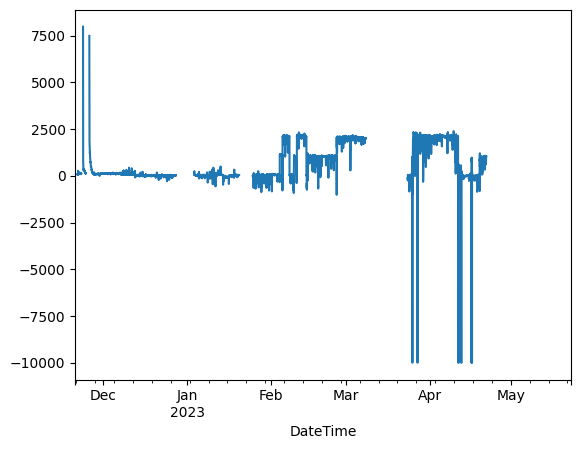

In [7]:
sensor_dataframe['measuring'].plot()

### Smooth data with a window of 4 samples, i.e.: an hour of data

<Axes: xlabel='DateTime'>

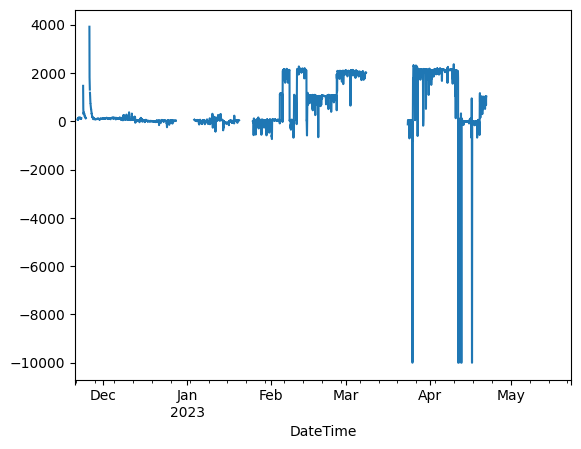

In [8]:
sensor_dataframe['raw measuring'] = sensor_dataframe['measuring']
sensor_dataframe['measuring'] = sensor_dataframe['measuring'].rolling(window=4).median()
sensor_dataframe['measuring'].plot()

### Convert to mg/m3

In [9]:
sensor_dataframe['value'] = sensor_dataframe['measuring'].map(lambda v: 0.0409*v*M/1e3)

## Tag data
Apply tags to the data according to the quality control processes described above

In [10]:
sensor_dataframe['Tag'] = 'VALID'

#### Tag data during stabilizing period
AQMesh recomends to considering the first two days after installation as a period for stabilization. In our case, a period of seven days was selected in order to remove outliers candidates detected during that period. For that purpose we detect the first 7 days of uninterrupted measurements

,latitude,longitude,measuring,raw measuring,value,Tag
DateTime,,,,,,
2022-11-20 13:45:00,-28.456899,-48.972999,NaN,125.92,NaN,STABILIZING
2022-11-20 14:00:00,NaN,NaN,NaN,NaN,NaN,STABILIZING
2022-11-20 14:15:00,NaN,NaN,NaN,NaN,NaN,STABILIZING
2022-11-20 14:30:00,NaN,NaN,NaN,NaN,NaN,STABILIZING
2022-11-20 14:45:00,NaN,NaN,NaN,NaN,NaN,STABILIZING


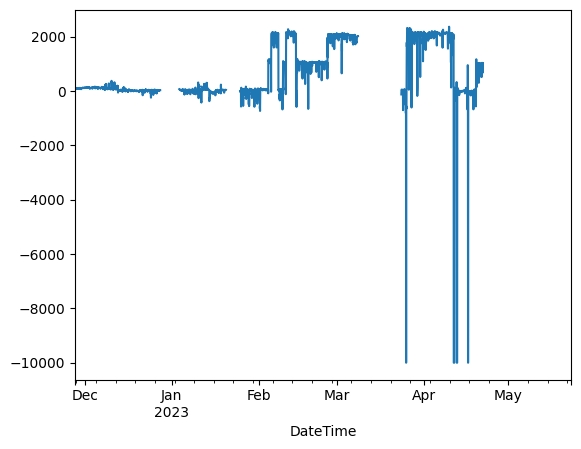

In [11]:
# Identify consecutive measurements (15 mins between each)
consecutive_periods = sensor_dataframe.index.to_series().diff().dt.seconds == 900

# Select the first seven days of consecutive measurements (96 = 24 * 60 mins / 15 mins, amount of 15 mins periods in a day)
last_stabilizing_index = sensor_dataframe[consecutive_periods].head(96 * 7).index[-1] # 7 days
sensor_dataframe.loc[sensor_dataframe.index[0]:last_stabilizing_index,'Tag'] = 'STABILIZING'
sensor_dataframe[sensor_dataframe['Tag'] == 'VALID']['measuring'].resample('15T').mean().plot()
sensor_dataframe.head()

#### Tag values that are missing, are greater than sensor span or are lower than sensor resolution

The upper limit was too high that affected the graph resolution, therefore it is not plotted

<Axes: xlabel='DateTime'>

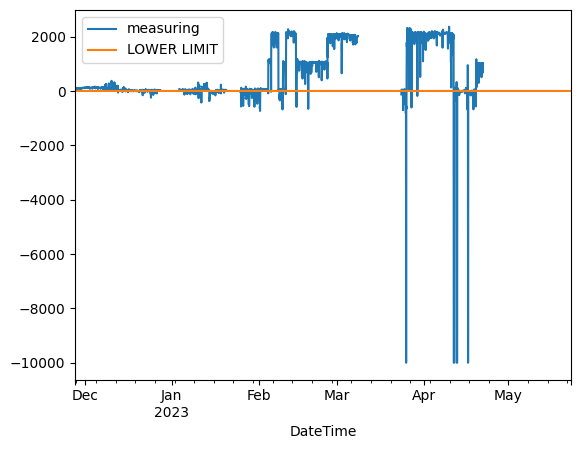

In [12]:
sensor_dataframe['UPPER LIMIT'] = upper_limit
sensor_dataframe['LOWER LIMIT'] = lower_limit
sensor_dataframe[sensor_dataframe['Tag'] == 'VALID'][['measuring', 'LOWER LIMIT']].resample('15T').mean().plot()

In [13]:
import numpy as np
from SensorDataAnalysisService import SensorDataAnalysisService as sensor_analysis

def tag_by_sensor_limits(value, tag, lower_limit, upper_limit):
 if (tag != 'VALID'): return tag
 return sensor_analysis.get_tags_from_series(value=value,
                                             lower_limit=lower_limit,
                                             upper_limit=upper_limit)

sensor_dataframe['Tag'] = (sensor_dataframe[['measuring', 'Tag']]
                                        .apply(lambda df: tag_by_sensor_limits(value=df[0], tag=df[1],
                                                                              lower_limit=lower_limit,
                                                                              upper_limit=upper_limit),
                                                axis=1))

#### Plot valid data after removing samples bellow lower limit

<Axes: xlabel='DateTime'>

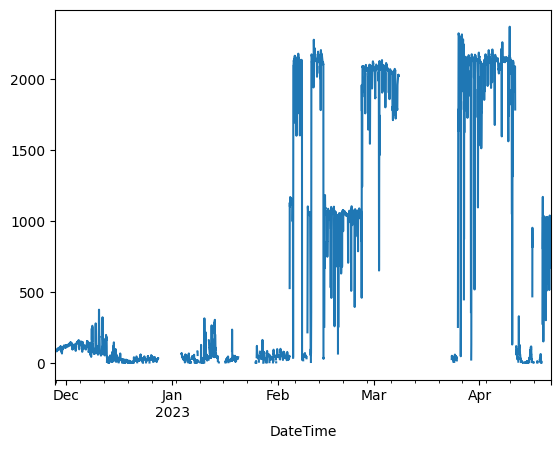

In [14]:
sensor_dataframe[sensor_dataframe['Tag'] == 'VALID']['measuring'].resample('15T').mean().plot()

#### Tag values with derivatives faster than sensor response time
The value of 3000 ppb was selected based on the maximum derivative found in the reference data. The maximum derivative (with measuring period of 1 hour) found was 4000 ppb. Therefore, a maximum of 3000 ppb was considered appropriate for a 15 mins period.

<Axes: xlabel='DateTime'>

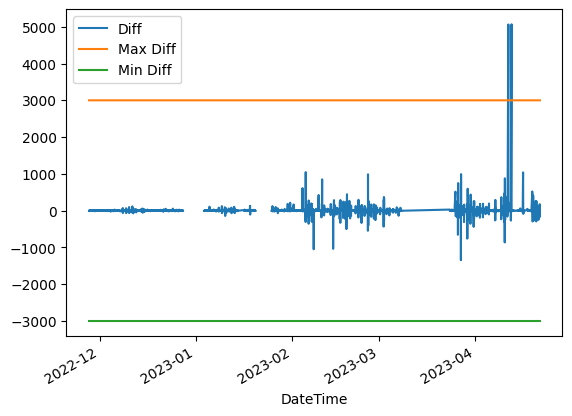

In [15]:
max_diff_value = 3000
sensor_dataframe['Diff'] = sensor_dataframe['measuring'].resample('15T').mean().diff()
sensor_dataframe['Max Diff'] = max_diff_value
sensor_dataframe['Min Diff'] = -max_diff_value
sensor_dataframe[sensor_dataframe['Tag'] == 'VALID'][['Diff', 'Max Diff', 'Min Diff']].plot()

In [16]:
import numpy as np

def tag_data_with_derivatives(tagged_df, max_diff_value):
        current_tag = tagged_df[0]
        value = tagged_df[1]
        if ((current_tag != 'VALID') or (np.isnan(value))): return current_tag
        if ((value > max_diff_value) or (value < -max_diff_value)): return 'BADSPIKE'
        return 'VALID'

sensor_dataframe['Tag'] = (sensor_dataframe[['Tag', 'Diff', 'Max Diff']]
                           .apply(lambda df: tag_data_with_derivatives(tagged_df=df, max_diff_value=df[2]),
                                   axis=1))

### Data Tag contabilization

In [17]:
tags = ['MISSING','LTLL', 'GTUL', 'STABILIZING', 'BADSPIKE', 'VALID']
data_contabilization = sensor_analysis.count_tags(tags, sensor_dataframe)
data_contabilization

,#,%
MISSING,5756,32.617442
LTLL,1560,8.840029
GTUL,0,0.0
STABILIZING,673,3.813679
BADSPIKE,2,0.011333
VALID,9656,54.717516
TOTAL,17647,100.0


## Analyse valid data

The graph shows the time series of the valid data, box plots of the data grouped by hour of the day, and histogram of the data.

/Users/Fernando/Documents/Projects/Github/lcqar-low-cost-monit-proc/data-pre-processing/SensorDataAnalysisService.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hour'] = df['Hour'].astype('int64')


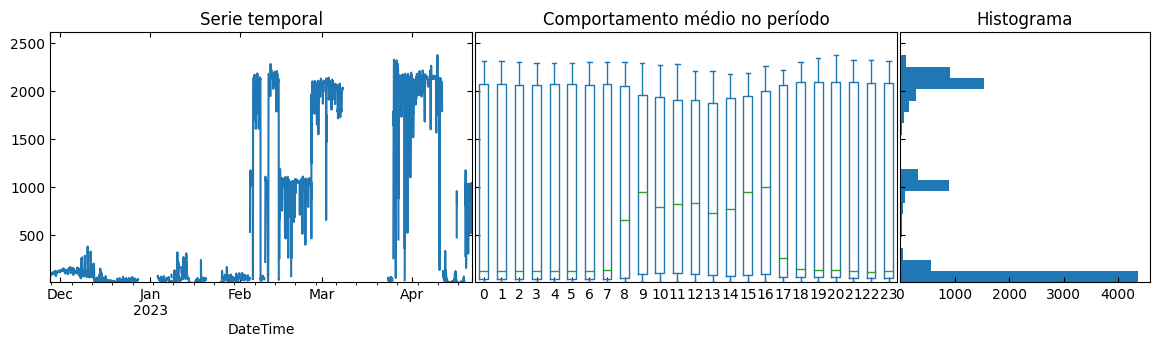

In [18]:
sensor_dataframe['Hour'] = sensor_dataframe.index.hour
valid_dataframe = sensor_dataframe[sensor_dataframe['Tag'] == 'VALID'].drop(columns=['Tag']).resample('15T').mean()
sensor_analysis.plot_box_hist(df=valid_dataframe, bins=20)

### Box plots by months

<Axes: title={'center': 'Comportamento médio no período'}>

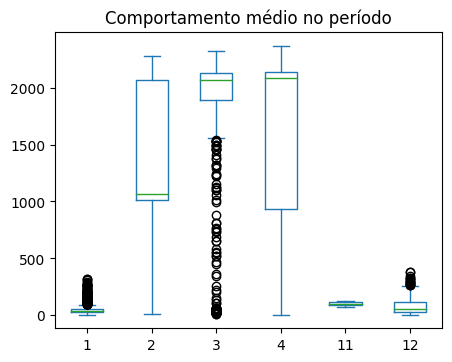

In [19]:
import matplotlib.pylab as plt

sensor_dataframe['Month'] = sensor_dataframe.index.month

df = sensor_dataframe[sensor_dataframe['Tag'] == 'VALID'] 
df = df.dropna(axis='index', how='all', subset=['Month'])
df['Month'] = df['Month'].astype('int64')
plt.figure(figsize=(5, 5/1.3))
ax_box  = plt.axes()
df.pivot(columns='Month')['measuring'].dropna(
        axis='columns', how='all').plot.box(
            ax=ax_box,title='Comportamento médio no período')

### Calculate quantiles

We calculated the 1% and 99 % quantiles of every hour of the day. The values greater outside the 1 % - 99 % where tagged as Greater that Quantile 99 (GTQTLE99) and Lower than Quantile 1 (LTQTLE01)

<Axes: xlabel='DateTime'>

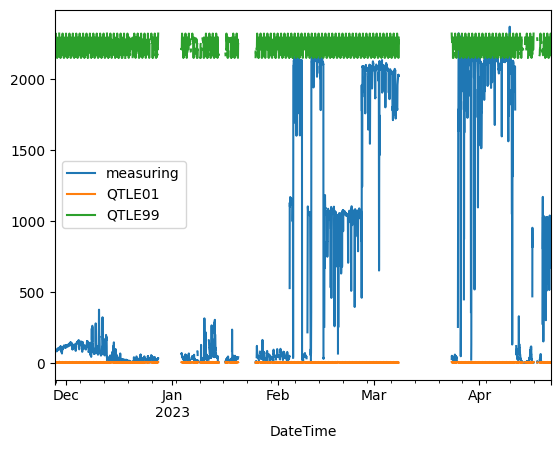

In [20]:
import numpy as np

global_qtle_01 = valid_dataframe.pivot(columns='Hour')['measuring'].quantile(q=0.01, axis='index', interpolation='lower').dropna()
global_qtle_99 = valid_dataframe.pivot(columns='Hour')['measuring'].quantile(q=0.99, axis='index', interpolation='higher').dropna()
sensor_dataframe['QTLE01'] = sensor_dataframe['Hour'].map(lambda hr: global_qtle_01[hr] if (not np.isnan(hr)) else np.nan)
sensor_dataframe['QTLE99'] = sensor_dataframe['Hour'].map(lambda hr: global_qtle_99[hr] if (not np.isnan(hr)) else np.nan)
sensor_dataframe[sensor_dataframe['Tag'] == 'VALID'][['measuring', 'QTLE01', 'QTLE99']].resample('15T').mean().plot()

### Tag data according to quantiles

In [21]:
sensor_dataframe['Tag'] = (sensor_dataframe[['Tag', 'measuring', 'QTLE01', 'QTLE99']]
                           .apply(lambda df: sensor_analysis.tag_by_quantiles(current_tag=df[0],
                                                                              value=df[1],
                                                                              quantile_01=df[2],
                                                                              quantile_99=df[3]),
                                axis=1))
tags = ['MISSING','LTLL', 'GTUL', 'BADSPIKE', 'VALID', 'LTQTLE01', 'GTQTLE99']
data_contabilization = sensor_analysis.count_tags(tags, sensor_dataframe)
data_contabilization

,#,%
MISSING,5756,32.617442
LTLL,1560,8.840029
GTUL,0,0.0
BADSPIKE,2,0.011333
VALID,9425,53.408511
LTQTLE01,116,0.657336
GTQTLE99,115,0.651669
TOTAL,17647,100.0


#### Plot valid data

<Axes: xlabel='DateTime'>

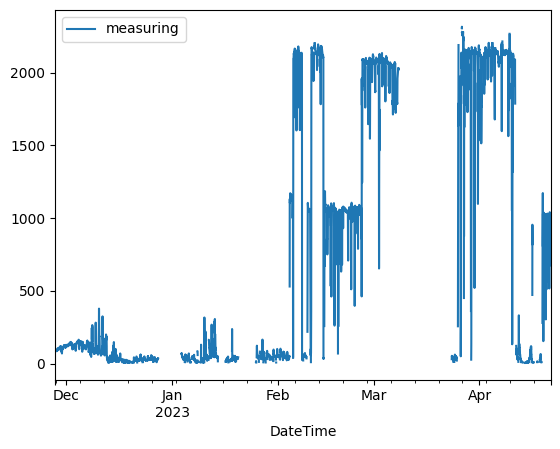

In [22]:
sensor_dataframe[sensor_dataframe['Tag'] == 'VALID'][['measuring']].resample('15T').mean().plot()

#### Analyse data after removing quantiles

/Users/Fernando/Documents/Projects/Github/lcqar-low-cost-monit-proc/data-pre-processing/SensorDataAnalysisService.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hour'] = df['Hour'].astype('int64')


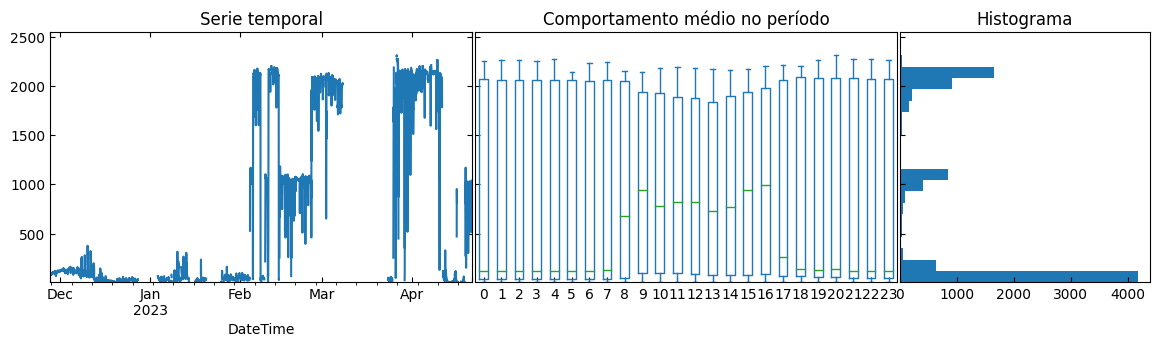

In [23]:
valid_dataframe = sensor_dataframe[sensor_dataframe['Tag'] == 'VALID'].drop(columns=['Tag']).resample('15T').mean()
sensor_analysis.plot_box_hist(df=valid_dataframe, bins=20)

## Analyse data derivatives

Analyse the derivatives of the data for removing abrupt changes in the data (BADSPIKE)

<Axes: xlabel='DateTime'>

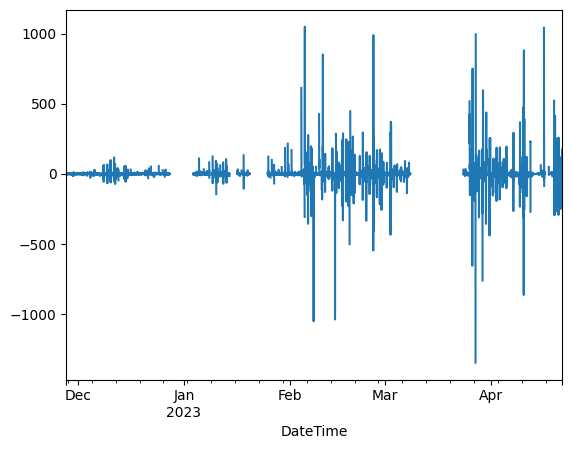

In [24]:
sensor_dataframe[sensor_dataframe['Tag'] == 'VALID']['Diff'].resample('15T').mean().plot()

#### Plot data derivatives vs data

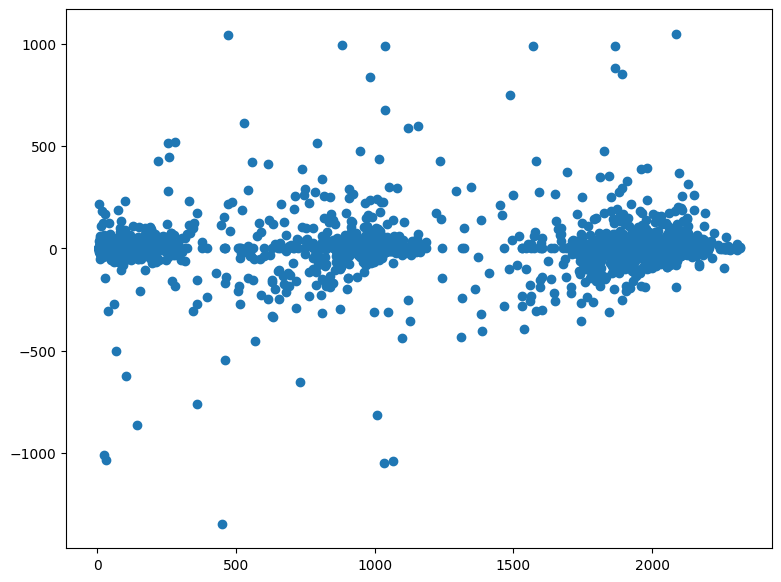

In [25]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(1.3*7,7))
plt.scatter(valid_dataframe['measuring'], valid_dataframe['Diff'])

### Calculate quantiles of the derivatives

<Axes: xlabel='DateTime'>

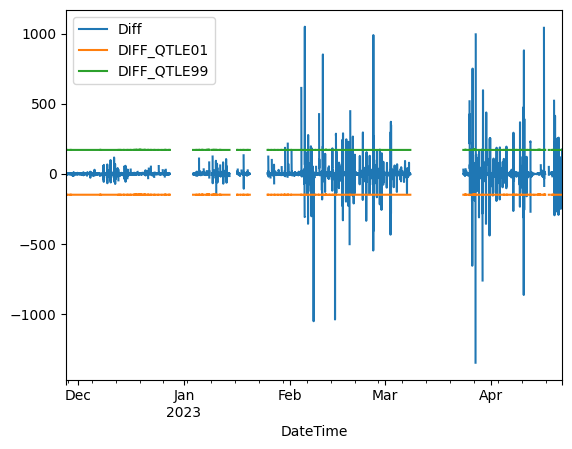

In [26]:
import numpy as np

global_qtle_01 = valid_dataframe['Diff'].quantile(q=0.01, interpolation='lower')
global_qtle_99 = valid_dataframe['Diff'].quantile(q=0.99, interpolation='higher')
sensor_dataframe['DIFF_QTLE01'] = global_qtle_01
sensor_dataframe['DIFF_QTLE99'] = global_qtle_99
sensor_dataframe[sensor_dataframe['Tag'] == 'VALID'][['Diff', 'DIFF_QTLE01', 'DIFF_QTLE99']].resample('15T').mean().plot()

### Tag data according to the quantiles of the derivatives

In [27]:
def tag_by_diff_quantiles(current_tag, value, quantile_01, quantile_99):
    if ((current_tag != 'VALID') or (np.isnan(value))): return current_tag
    if value <= quantile_01 or value >= quantile_99: return 'BADSPIKE'
    return 'VALID'

sensor_dataframe['Tag'] = (sensor_dataframe[['Tag', 'Diff', 'DIFF_QTLE01', 'DIFF_QTLE99']]
                           .apply(lambda df: tag_by_diff_quantiles(current_tag=df[0],
                                                                    value=df[1],
                                                                    quantile_01=df[2],
                                                                    quantile_99=df[3]),
                                    axis=1))
tags = ['MISSING','LTLL', 'GTUL', 'BADSPIKE', 'VALID', 'LTQTLE01', 'GTQTLE99']
data_contabilization = sensor_analysis.count_tags(tags, sensor_dataframe)
data_contabilization

,#,%
MISSING,5756,32.617442
LTLL,1560,8.840029
GTUL,0,0.0
BADSPIKE,192,1.088004
VALID,9235,52.331841
LTQTLE01,116,0.657336
GTQTLE99,115,0.651669
TOTAL,17647,100.0


#### Plot valid data

<Axes: xlabel='DateTime'>

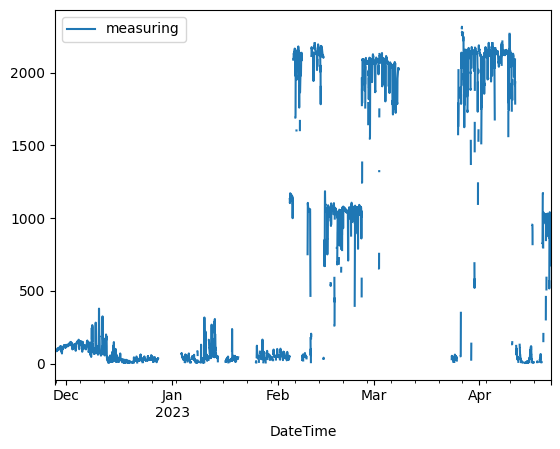

In [28]:
sensor_dataframe[sensor_dataframe['Tag'] == 'VALID'][['measuring']].resample('15T').mean().plot()

/Users/Fernando/Documents/Projects/Github/lcqar-low-cost-monit-proc/data-pre-processing/SensorDataAnalysisService.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hour'] = df['Hour'].astype('int64')


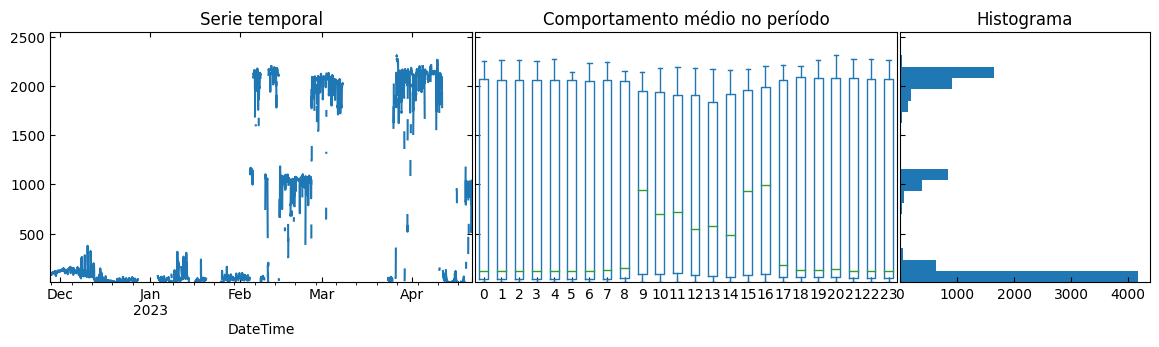

In [29]:
valid_dataframe = sensor_dataframe[sensor_dataframe['Tag'] == 'VALID'].drop(columns=['Tag']).resample('15T').mean()
sensor_analysis.plot_box_hist(df=valid_dataframe, bins=20)

## Resample valid data to 1 HR

<Axes: xlabel='DateTime'>

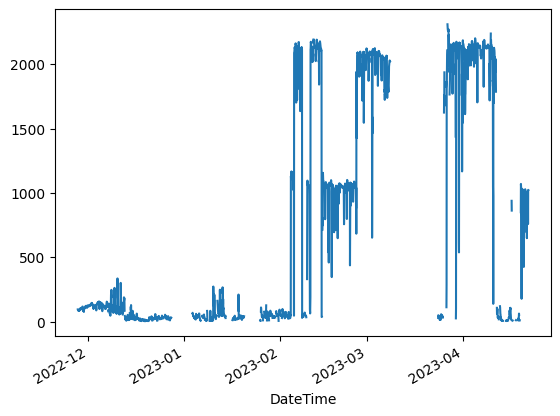

In [30]:
resampled_dataframe = sensor_dataframe[sensor_dataframe['Tag'] == 'VALID'].drop(columns=['Tag']).resample('H').mean()
resampled_dataframe['Hour'] = resampled_dataframe.index.hour
resampled_dataframe['Count'] = (valid_dataframe['measuring'].resample('H').count())
resampled_dataframe['Std'] = (valid_dataframe['measuring'].resample('H').std())
resampled_dataframe.index = resampled_dataframe.index.map(lambda t: t.replace(minute=30, second=0))
resampled_dataframe['measuring'].plot()

#### Tag hourly data according to the number of samples in an hour
At least 3 samples must be valid in an hour (75 %) for the hourly data be considered as valid

<Axes: xlabel='DateTime'>

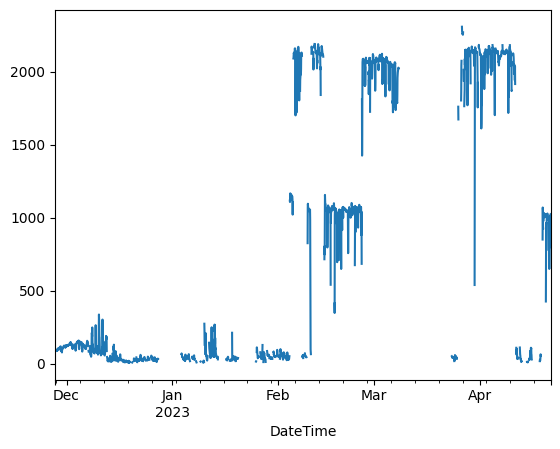

In [31]:
original_freq = sensor_dataframe.index.freq
resampled_dataframe['% valid'] = (resampled_dataframe['Count']
                                    .map(lambda c:
                                        c / (pd.Timedelta("1 hour") / original_freq) * 100))
resampled_dataframe['Tag'] = (resampled_dataframe['% valid']
                                .map(lambda c: 'VALID' if c >= 75 else 'LOWSAMPLES'))
resampled_dataframe[resampled_dataframe['Tag'] == 'VALID']['measuring'].resample('H').mean().plot()

#### Valid data contabilization

In [32]:
tags = ['LOWSAMPLES','VALID'] 
data_contabilization = sensor_analysis.count_tags(tags, resampled_dataframe)
data_contabilization

,#,%
LOWSAMPLES,1220,34.977064
VALID,2268,65.022936
TOTAL,3488,100.0


## Analyse the mean and standard deviation of the resampled data

The color of each data point represents the percentage of valid 15 mins samples found in an hour

#### Plot mean (Y axis) vs. standard deviation (X axis) for valid hourly data colored by valid percentage of valid samples

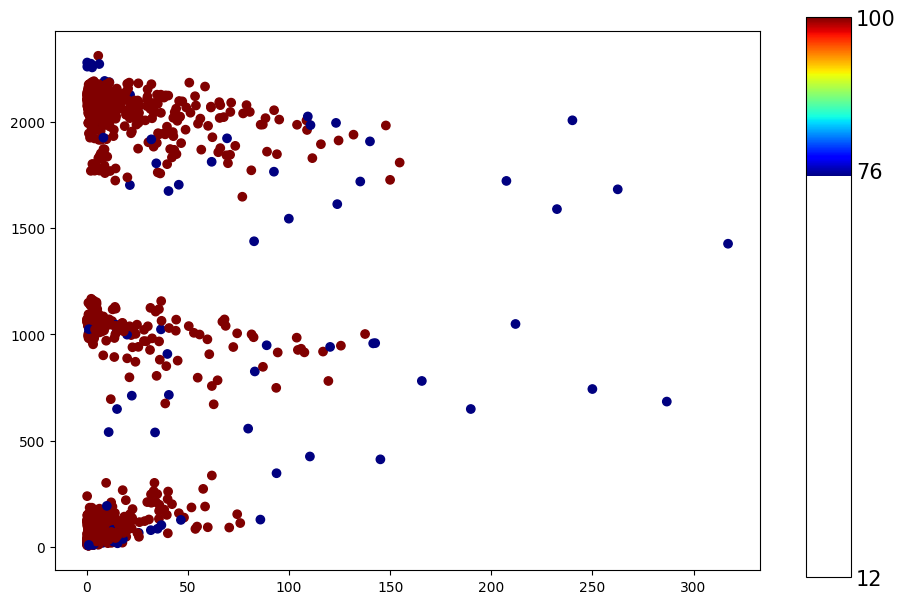

In [33]:
valid_resampled_dataframe = resampled_dataframe[resampled_dataframe['Tag'] == 'VALID']
sensor_analysis.plot_mean_vs_std(valid_resampled_dataframe)

### Plot standard deviation in time colored according to the percentage of valid samples

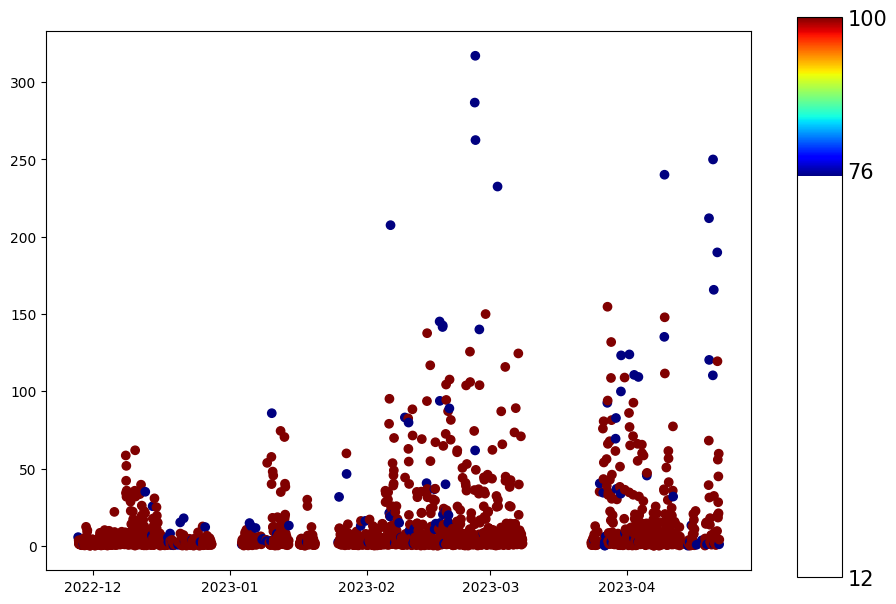

In [34]:
sensor_analysis.plot_std_in_time(valid_resampled_dataframe)

# Save Data

In [35]:
import os

output_directory_path = 'data/output/'
processing_directory_path = '../data-processing/input/'
valid_1HR_filename = 'valid_data_1HR.csv'
valid_filename = 'valid_data.csv'
dataframe_filename = 'dataframe.csv'
dataframe_1HR_filename = 'dataframe_1hr.csv'

valid_1HR_file_path_output = output_directory_path + sensor_name + valid_1HR_filename
valid_file_path_output = output_directory_path + sensor_name + valid_filename

dataframe_path_1HR_output = output_directory_path + sensor_name + dataframe_1HR_filename
dataframe_path_output = output_directory_path + sensor_name + dataframe_filename

valid_processing_1HR_file_path = processing_directory_path + sensor_name + valid_1HR_filename
valid_processing_file_path = processing_directory_path + sensor_name + valid_filename

processing_dataframe_path_1HR = processing_directory_path + sensor_name + dataframe_1HR_filename
processing_dataframe_path = processing_directory_path + sensor_name + dataframe_filename

if not os.path.exists(output_directory_path):
    os.makedirs(output_directory_path)

if not os.path.exists(processing_directory_path):
    os.makedirs(processing_directory_path)

sensor_dataframe[sensor_dataframe['Tag'] == 'VALID'][['measuring', 'value']].to_csv(valid_file_path_output)
valid_resampled_dataframe[['measuring', 'value']].to_csv(valid_1HR_file_path_output)
sensor_dataframe.to_csv(dataframe_path_output)
resampled_dataframe.to_csv(dataframe_path_1HR_output)

sensor_dataframe[sensor_dataframe['Tag'] == 'VALID'][['measuring', 'value']].to_csv(valid_processing_file_path)
valid_resampled_dataframe[['measuring', 'value']].to_csv(valid_processing_1HR_file_path)
sensor_dataframe.to_csv(processing_dataframe_path)
resampled_dataframe.to_csv(processing_dataframe_path_1HR)


## Change point Analysis

### Change point analysis of 15 mins data

In [36]:
import ruptures as rpt

series = sensor_dataframe[sensor_dataframe['Tag'] == 'VALID']['measuring']
signal = np.array(series).reshape(-1, 1)
algo = rpt.Pelt(model="rbf", jump=50, min_size=100).fit(signal=signal)
result = algo.predict(pen=10)
result

[4300, 4400, 4600, 4700, 4800, 5150, 6150, 7150, 7300, 8700, 9000, 9235]

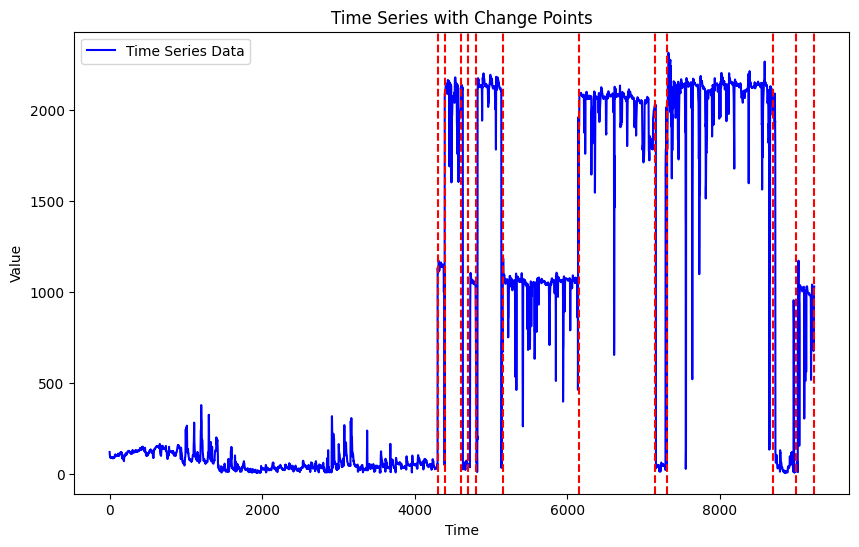

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(signal, label='Time Series Data', color='blue')

# Plot change points
for point in result:
    plt.axvline(x=point, color='red', linestyle='--')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series with Change Points')

# Show the plot
plt.legend()
plt.show()

### Change point analysis of hourly data

In [38]:
import ruptures as rpt

series = resampled_dataframe[resampled_dataframe['Tag'] == 'VALID']['measuring']
signal = np.array(series).reshape(-1, 1)
algo = rpt.Pelt(model="rbf", min_size=10).fit(signal=signal)
result = algo.predict(pen=10)
result

[1055, 1075, 1135, 1185, 1260, 1515, 1765, 1795, 2150, 2215, 2268]

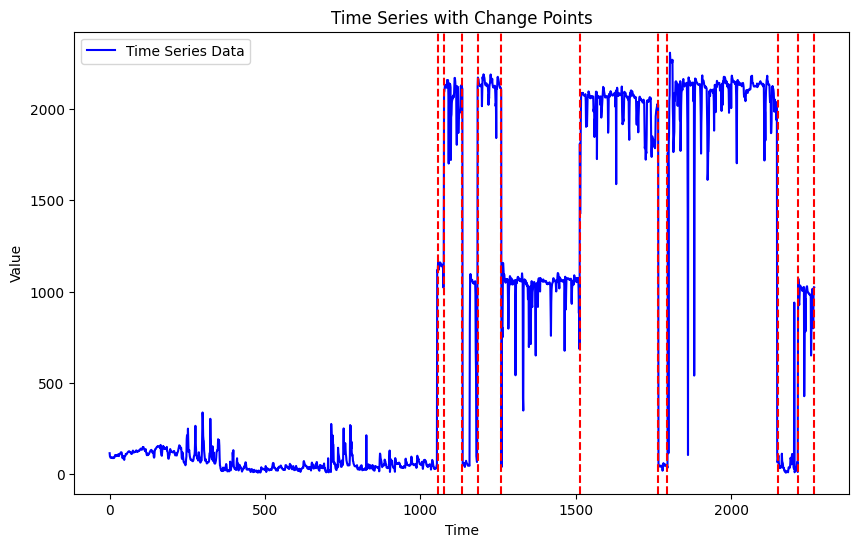

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(signal, label='Time Series Data', color='blue')

# Plot change points
for point in result:
    plt.axvline(x=point, color='red', linestyle='--')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series with Change Points')

# Show the plot
plt.legend()
plt.show()